In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

Connect Google Drive.  This is done so that the models and data reading can be standard across the different testing environments and any changes will be universal.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/Weather')

from high_low import MultiHeadModel, LSTM_Model, Dense_Model
from process import df_to_np_hl

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


df_to_np is a helper functions to convert csv to training data format

x = last (context_window) readings

y = [next day high, next day low]

If there is a blank or invalid value, that blank is replaced with the most recent valid reading for that feature.

In [7]:
def replace_blanks(df):
  '''Replaces all invalids with the most recent valid in that column'''
  df = df.replace('', np.nan)
  df = df.fillna(method='ffill')
  df = df.dropna()

  return df

Read in the data

In [4]:
context_window = 48

In [91]:
df_train = pd.read_csv('/content/processed_data/train.csv')
df_train = df_train.set_index(['USAF ID',
                               'Observation Year',
                               'Observation Month',
                               'Observation Day',
                               'Observation Hour'])

df_test = pd.read_csv('/content/processed_data/test.csv')
df_test = df_test.set_index(['USAF ID',
                             'Observation Year',
                             'Observation Month',
                             'Observation Day',
                             'Observation Hour'])

start_year, end_year = 2010, 2024
USAFs_train = ['720553', '744860', '725030', '725020', '725053']
USAFs_test = ['744864']

df_train = replace_blanks(df_train)
df_test = replace_blanks(df_test)

x_train, y_train = df_to_np_hl(df_train, USAFs_train, start_year, end_year, context_window, True)
x_test, y_test = df_to_np_hl(df_test, USAFs_test, start_year, end_year, context_window, True)

print(f'{len(x_train)} training samples')
print(f'{len(x_test)} testing samples')

1/5
2/5
3/5
4/5
5/5
1/1
571074 training samples
126964 testing samples


Normalize the data before training

In [92]:
from sklearn.preprocessing import MinMaxScaler

timesteps = len(x_train[0])
features = len(x_train[0][0])

x_train_reshaped = x_train.reshape(len(x_train) * timesteps, -1)
x_test_reshaped = x_test.reshape(len(x_test) * timesteps, -1)

scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train_reshaped)
x_test_scaled = scaler.transform(x_test_reshaped)

x_train = x_train_scaled.reshape(len(x_train), timesteps, features)
x_test = x_test_scaled.reshape(len(x_test), timesteps, features)

Shuffle order

In [93]:
indices = np.random.permutation(len(x_train))

x_train = x_train[indices]
y_train = y_train[indices]

Build Validation Set

In [94]:
valid_split = int(len(x_train) * 0.05)

x_valid = x_train[:valid_split]
y_valid = y_train[:valid_split]

x_train = x_train[valid_split:]
y_train = y_train[valid_split:]

Build the model

In [95]:
from tensorflow.keras.layers import Input, MultiHeadAttention, Add, LayerNormalization, Dense

seq_len = context_window  # Length of time series
d_model = 7  # Single entry dimension
num_heads = 8  # Number of attention heads
out_dim = 2
batch_size = 8

Multihead Attention Approach

In [96]:
model = MultiHeadModel(seq_len, d_model, num_heads)

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 48, 7)]              0         []                            
                                                                                                  
 mha1 (MultiHeadAttention)   (None, 48, 7)                1743      ['input[0][0]',               
                                                                     'input[0][0]',               
                                                                     'input[0][0]']               
                                                                                                  
 add1 (Add)                  (None, 48, 7)                0         ['input[0][0]',               
                                                                     'mha1[0][0]']          

LSTM Approach

In [82]:
model = LSTM_Model(seq_len, d_model)

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 48, 7)]              0         []                            
                                                                                                  
 lstm1 (LSTM)                (None, 48, 7)                420       ['input[0][0]']               
                                                                                                  
 add1 (Add)                  (None, 48, 7)                0         ['input[0][0]',               
                                                                     'lstm1[0][0]']               
                                                                                                  
 norm1 (LayerNormalization)  (None, 48, 7)                14        ['add1[0][0]']          

In [ ]:
model = Dense_Model(seq_len, d_model)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 48, 7)]           0         
                                                                 
 flatten (Flatten)           (None, 336)               0         
                                                                 
 dense1 (Dense)              (None, 336)               113232    
                                                                 
 dense2 (Dense)              (None, 150)               50550     
                                                                 
 output (Dense)              (None, 2)                 302       
                                                                 
Total params: 164084 (640.95 KB)
Trainable params: 164084 (640.95 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [97]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-7)
model.compile(loss='mean_squared_error', optimizer=opt)

In [98]:
# Train the model and store model parameters/loss values
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=10, validation_data=[x_valid, y_valid], callbacks=[reduce_lr])#, shuffle=True)

Epoch 1/10
67816/67816 [==============================] - 1587s 23ms/step - loss: 15.6000 - val_loss: 14.1046 - lr: 0.0010
Epoch 2/10
67816/67816 [==============================] - 1575s 23ms/step - loss: 13.3223 - val_loss: 13.1455 - lr: 0.0010
Epoch 3/10
67816/67816 [==============================] - 1571s 23ms/step - loss: 12.5116 - val_loss: 12.1844 - lr: 0.0010
Epoch 4/10
67816/67816 [==============================] - 1578s 23ms/step - loss: 12.0161 - val_loss: 11.6268 - lr: 0.0010
Epoch 5/10
67816/67816 [==============================] - 1564s 23ms/step - loss: 11.6560 - val_loss: 12.3277 - lr: 0.0010
Epoch 6/10
67816/67816 [==============================] - 1546s 23ms/step - loss: 11.3867 - val_loss: 11.4994 - lr: 0.0010
Epoch 7/10
67816/67816 [==============================] - 1562s 23ms/step - loss: 11.1691 - val_loss: 12.9339 - lr: 0.0010
Epoch 8/10
67816/67816 [==============================] - 1557s 23ms/step - loss: 10.9625 - val_loss: 11.2557 - lr: 0.0010
Epoch 9/10
67816

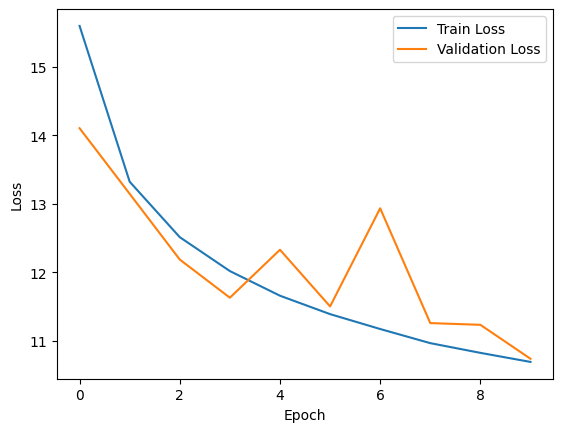

In [102]:
# Plot the loss curve
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Validation Loss'])
plt.show()

In [100]:
x_test = np.array(x_test)
y_test = np.array(y_test)
model.evaluate(x_test, y_test, batch_size=64)

1984/1984 [==============================] - 111s 56ms/step - loss: 11.9183


11.918306350708008

In [101]:
num_samples = 10
X = model.predict(np.array(x_test[:num_samples]))
for i in range(num_samples):
  print(f'Prediction:   {X[i]} \nGround Truth: {y_test[i]} \n')


1/1 [==============================] - 0s 323ms/step
Prediction:   [ 1.1309974 -5.401285 ] 
Ground Truth: [ 0.  -6.7] 

Prediction:   [ 1.3378496 -4.9978833] 
Ground Truth: [ 0.  -6.7] 

Prediction:   [ 0.13834381 -5.224445  ] 
Ground Truth: [ 0.  -6.7] 

Prediction:   [ 4.1575432e-03 -5.4810023e+00] 
Ground Truth: [ 0.  -6.7] 

Prediction:   [-0.08982754 -5.5781307 ] 
Ground Truth: [ 0.  -6.7] 

Prediction:   [-0.06664324 -5.6174364 ] 
Ground Truth: [ 0.  -6.7] 

Prediction:   [ 0.21263361 -5.606994  ] 
Ground Truth: [ 0.  -6.7] 

Prediction:   [ 0.68432546 -5.2761974 ] 
Ground Truth: [ 0.  -6.7] 

Prediction:   [ 1.0909538 -4.953083 ] 
Ground Truth: [ 0.  -6.7] 

Prediction:   [ 0.5991268 -5.2304053] 
Ground Truth: [ 0.  -6.7] 

